In [1]:
import pandas as pd
import numpy as np
import struct
import sys
import time
import warnings
import matplotlib.pyplot as plt 

warnings.filterwarnings("ignore")
#sys.se
#required files: mol.csv contains element mass/charge informations

In [11]:
def readpdb(fi='target.pdb',libfile='mol.csv'):
    pdb=open(fi,'r')
    index=[]
    name=[]
    resname=[]
    chain=[]
    resid=[]
    x=[]
    y=[]
    z=[]
    charge=[]
    element=[]
    mass=[]
    atomdict={}
    lib=pd.read_csv(libfile)
    lib.element=lib.element.fillna('NA')
    for i in lib.index:
        atomdict[lib.element[i]]=[lib.mass[i]]
    lines=pdb.readlines()
    print(atomdict)
    for line in lines:
        if line[0:4] == 'ATOM':
            index.append(int(line[6:11]))
            n=line[12:16]
            name.append(n.strip())
            resname.append(line[17:20])
            resid.append(int(line[22:26]))
            x.append(float(line[30:38]))
            y.append(float(line[38:46]))
            z.append(float(line[46:54]))
            if len(line)<77 or line[76:78].strip()=='':
                element.append(n.strip()[0])
            else:
                element.append(line[76:78].strip())
            mass.append(atomdict[element[-1]][0])
#            charge.append(atomdict[element[-1]][1])
    data=pd.DataFrame({
        'series':index,
        'name':name,
        'resname':resname,
        'resid':resid,
        'x':x,
        'y':y,
        'z':z,
        'mass':mass,
#        'charge':charge,
        'element':element
    })
    data[['series', 'resid']] = data[['series', 'resid']].astype(int)
    pdb.close()
    return data
def writepdb(data,outfile='out.pdb'):
    pdb=open(outfile,'w')
    out=[]
    for i in data.index:
        out.append("ATOM  {0:>5} {1:<4} {2:<3} {3}{4:>4}    {5:>8.3f}{6:>8.3f}{7:>8.3f}                      {8:>2}\n"
              .format(int(data.series[i]),data.name[i],data.resname[i],
                      'X',int(data.resid[i]),data.x[i],data.y[i],data.z[i],
                      data.element[i]))
    pdb.writelines(out)
    pdb.close()
    return
def readtrj(inpfile='target.trj',ref=[],snap=(0,2500,1),name='traj'):
    start=time.perf_counter()
    data=open(inpfile,'rb')
    data.read(81)
    pos=np.zeros((len(ref.index),int((snap[1]-snap[0])/snap[2]),3),dtype=np.float16)
    for s in range(snap[0],snap[1],snap[2]):
        count=0
#        print('read frame ',s)
        for i in range(0,len(ref.index)):
            for x in range(0,3):
                pos[i][s][x]=float(data.read(8))
                count+=1
                if count>=10:
                    data.read(1)
                    count=0
        data.read(26)
        ref[name+'x'+str(s)]=pos[:,s,0]
        ref[name+'y'+str(s)]=pos[:,s,1]
        ref[name+'z'+str(s)]=pos[:,s,2]
    data.close()
    end=time.perf_counter()
    print("read trajectory for {0:>8.3f} s".format(end-start))
    return ref
def writetrj(data,outfile='out.trj',trajname='traj',snap=(0,2500,1),title='Amber trjectory file write by quzhi'):
    start=time.perf_counter()
    fo=open(outfile,'w')
    fo.write("{0:<80}\n".format(title))
    for s in range(snap[0],snap[1],snap[2]):
        outdata=""
        x=trajname+'x'+str(s)
        y=trajname+'y'+str(s)
        z=trajname+'z'+str(s)
        count=0
        for i in data.index:
            outdata+="{0:>8.3f}".format(data[x][i])
            outdata+="{0:>8.3f}".format(data[y][i])
            outdata+="{0:>8.3f}".format(data[z][i])
        for i in range(int(len(outdata)/80)):
            fo.write(outdata[i*80:i*80+80]+'\n')
        if (len(outdata)%80)!=0:
            fo.write(outdata[i*80+80:]+'\n')
        fo.write("{0:>8.3f}{1:>8.3f}{2:>8.3f}\n".format(9999,9999,9999))
    fo.close()
    end=time.perf_counter()
    print("write trajectory for {0:>8.3f} s".format(end-start))
    return
def writeparm(data,parmfile='out.parm'):
#this parm file do not contain parameters!!!!!
#only use for curve analysis
    fp=open(parmfile,'w')
    fp.writelines('''%VERSION  VERSION_STAMP = V0001.000  DATE = 10/09/21 20:21:36                  
%FLAG TITLE                                                                     
%FORMAT(20a4)                                                                   
default_name                                                                    
%FLAG POINTERS                                                                  
%FORMAT(10I8)
''')
    fp.writelines("{0:>8d}{1:>8d}{2:>8d}{3:>8d}{4:>8d}{5:>8d}{6:>8d}{7:>8d}{8:>8d}{9:>8d}\n".\
    format(len(data.index),len(data.name.value_counts()),0,0,0,0,0,0,0,0))
#  NATOM    : total number of atoms 
#  NTYPES   : total number of distinct atom types
    fp.writelines("{0:>8d}{1:>8d}{2:>8d}{3:>8d}{4:>8d}{5:>8d}{6:>8d}{7:>8d}{8:>8d}{9:>8d}\n".\
    format(0,len(data.resid.value_counts()),0,0,0,0,0,0,0,0))
#resid now only support amber format pdb
#
    fp.writelines('''%FLAG ATOM_NAME                                                                 
%FORMAT(20a4)                                                                                                                               
''')
    line=''
    count=0
    for i in data.index:
        line=line+"{0:<4}".format(data.name[i])
    for i in range(int(len(line)/80)):
        fp.write(line[i*80:i*80+80]+'\n')
    if (len(line)%80)!=0:
        fp.write(line[i*80+80:]+'\n')
    fp.writelines('''%FLAG RESIDUE_LABEL                                                             
%FORMAT(20a4)                                                                   
''')
    line=''
    count=0
    temp=''
    respointer=[]
    for i in data.index:
        if data.resid[i]!=temp:
            respointer.append(i+1)
            temp=data.resid[i]            
            line=line+"{0:<4}".format(data.resname[i])
    for i in range(int(len(line)/80)):
        fp.write(line[i*80:i*80+80]+'\n')
    if (len(line)%80)!=0:
        fp.write(line[i*80+80:]+'\n')
    fp.writelines('''%FLAG RESIDUE_POINTER                                                           
%FORMAT(10I8)                                                                   
''') 
    line=''
    count=0
    for i in respointer:
        line=line+"{0:>8d}".format(i)
        count+=1
    for i in range(int(len(line)/80)):
        fp.write(line[i*80:i*80+80]+'\n')
    if (len(line)%80)!=0:
        fp.write(line[i*80+80:]+'\n')
    fp.close()
    return

In [3]:
def select(data,selname='sel',sel={'index':[],'series':[],'name':[],'resname':[],'resid':[],'chain':[],'element':[]}):
#mode 1/0 represent select/deselect
#relation 1/0 represent and/or
    start=time.perf_counter()
    whole_sel=np.zeros(len(data))+1
    for name in sel:
        single_sel=np.zeros(len(data))
        for item in sel[name]:
            single_sel+= (data[name] == item)
        whole_sel=whole_sel*single_sel
    data[selname]=whole_sel
    end=time.perf_counter()
    print("generate selection for {0:>8.3f} s".format(end-start))                    
    return
def select_complex(data,selname='sel',mode=1,relation=1,sel={'index':[],'series':[],'name':[],'resname':[],'resid':[],'chain':[],'element':[]}):
#mode 1/0 represent select/deselect
#relation 1/0 represent and/or
    start=time.perf_counter()
    if relation==0:
        data[selname]=0
        for name in sel:
            if sel[name]:
                data[selname][data[name] in sel[name]]=mode
    else:
        data[selname]=1
        for name in sel:
            if sel[name]:
                for i in data.index:
                    if data[name][i] not in sel[name]:
                        data[selname][i]=1-mode
    end=time.perf_counter()
    print("generate selection for {0:>8.3f} s".format(end-start))                    
    return
def addcom(data,selname='sel',trajname='traj',weight='mass'):
    start=time.perf_counter()
    select=data[data[selname]==1]
    totalmass=select[weight].sum()
    com={'series':0,'resname':selname,'resid':len(data.resid.value_counts())+1,
         'mass':totalmass,'element':'X','name':selname,
         'x':select[weight].dot(select.x)/totalmass,
         'y':select[weight].dot(select.y)/totalmass,
         'z':select[weight].dot(select.z)/totalmass}
    for s in data:
        if s.startswith(trajname):            
            com[s]=select[weight].dot(select[s])/totalmass
    end=time.perf_counter()
    print("generate COM for {0:>8.3f} s".format(end-start))    
    return data.append(com,ignore_index=True)


In [4]:
from os      import system
import re
def genlib(data,selname='',flib='/home/pangpang/curve+/standard',pre='X',charge=1,mapfile='temp.csv'):
    system('mv '+flib+'_i.lib backup')
    fo=open(flib+'_i.lib','w')
    fm=open()
    count=0
    output=data['index','name','resid','resname',selname].copy
    for i in output.index:
        if output[selname][i]:
            fo.writelines(pre+"{:<3d}".format(count)+' '+str(charge)+'\n')
            fm.writelines(str(int(output.index[i]))+','+output.name[i]+','
                          +str(int(output.resid[i]))+','+output.resname[i]+','+pre+"{:<3d}".format(count)+',\n')
            count+=1
    fo.close()
    fm.close()
    return output

def curves(data,sel,deffnm='curve_dna',inp='',outdir='/home/pangpang',trajname='traj',
           snap=(0,800,1),libori='/home/pangpang/curve+/standard',pre='X',IFwritetrj=True):
#
    datap=data[['name','resname','resid']].copy()
    if inp=='':
        fi=open(deffnm+'.inp','w')
        fi.writelines('''export inp='''+deffnm+'''.trj
export parm='''+deffnm+'''.prmtop 
export out='''+deffnm+'''
/home/pangpang/curve+/Cur+ <<EOF
 &inp file=$inp, ftop=$parm, lis=$out, ions=.t., frames=.t.,
 lib='''+deffnm+''', &end
2 1 -1 0 0
1:20
40:21
EOF''')
        fi.close()
    print('sh command: cp '+libori+'_b.lib '+deffnm+'_b.lib')
    system('cp '+libori+'_b.lib '+deffnm+'_b.lib')
    print('sh command: cp '+libori+'_s.lib '+deffnm+'_s.lib') 
    system('cp '+libori+'_s.lib '+deffnm+'_s.lib')    
    fl=open(deffnm+'_i.lib','w')            
#standard_i.lib file in curves is now a map file write
    count=1
    for i in data[data[sel]==1].index:
        fl.writelines(pre+str(count)+'   '+str(i)+' \n')
        datap.loc[i,'name']=pre+str(count)
        count+=1
    fl.close()
    writeparm(datap,deffnm+'.prmtop')
    writetrj(data,outfile=deffnm+'.trj',trajname=trajname,snap=snap,title='taskname:'+deffnm+' for curves analysis')
    system('sh '+deffnm+'.inp')  
    readcdi(deffnm+'.cdi',ref=data).to_csv(deffnm+'.csv')
    system('mv '+deffnm+'* '+outdir)
    return 

def readcdi(fi,ref=''):
    cdi=open(fi,'r',encoding='utf-8')
    lines=cdi.readlines()
    index=lines[2].split()
    ionlist=lines[3].split()
    frames=int((len(lines)-5)/2)
    ions=len(index)
    table={}
    ionlist={}
    circle={}
    if type(ref)==pd.DataFrame:    
        c=1
        for i in index:
            ionlist[c]=ref['resname'][int(i)]#+str(ref['resid'][int(i)])+ref['name'][int(i)]
            circle[ionlist[c]]=0
            c+=1
    else:
        c=1
        for i in index:
            ionlist[c]=index
            c+=1
    for i in ionlist:
        table[ionlist[i]+'pos']=np.zeros(frames)
        table[ionlist[i]+'rad']=np.zeros(frames)
        table[ionlist[i]+'ang']=np.zeros(frames)
    f=-1
    ln=4
    print(frames)
    while ln<len(lines)-1:
        l=0
        f+=1
        ln+=1        
        ni=lines[ln]
        if ni.startswith('      0'):
            continue
        else:
            ni=int(ni)
            ln+=1
        line=lines[ln]
        for i in range(ni):
            ion=ionlist[int(line[l+26:l+28])]
            table[ion+'pos'][f]=float(line[l:l+7])/1000
            table[ion+'rad'][f]=float(line[l+7:l+14])/1000
            table[ion+'ang'][f]=float(line[l+14:l+21])*0.057324841
            l+=28
    curvesdata=pd.DataFrame(table)
    return curvesdata




In [5]:
def gapr(data):
    select(data,sel={'name':['CA']},selname='ALL')
    select(data,sel={'name':['CA'],'resid':[*range(43,62)]},selname='AN1')
    select(data,sel={'name':['CA'],'resid':[*range(63,80)]},selname='AC1')
    select(data,sel={'name':['CA'],'resid':[*range(121,140)]},selname='BN1')
    select(data,sel={'name':['CA'],'resid':[*range(141,158)]},selname='BC1')
    select(data,sel={'name':['CA'],'resid':[*range(199,218)]},selname='CN1')
    select(data,sel={'name':['CA'],'resid':[*range(219,236)]},selname='CC1')
    select(data,sel={'name':['CA'],'resid':[*range(277,296)]},selname='DN1')
    select(data,sel={'name':['CA'],'resid':[*range(297,314)]},selname='DC1')
    select(data,sel={'name':['CA'],'resid':[*range(84,95)]},selname='AA2')
    select(data,sel={'name':['CA'],'resid':[*range(162,173)]},selname='BA2')
    select(data,sel={'name':['CA'],'resid':[*range(240,251)]},selname='CA2')
    select(data,sel={'name':['CA'],'resid':[*range(318,329)]},selname='DA2')
    select(data,sel={'name':['CA'],'resid':[*range(98,115)]},selname='AA3')
    select(data,sel={'name':['CA'],'resid':[*range(176,193)]},selname='BA3')
    select(data,sel={'name':['CA'],'resid':[*range(254,271)]},selname='CA3')
    select(data,sel={'name':['CA'],'resid':[*range(332,349)]},selname='DA3')
    data=addcom(data,selname='ALL')
#    data=addcom(data,selname='AA1')
#    data=addcom(data,selname='BA1')
#    data=addcom(data,selname='CA1')
#    data=addcom(data,selname='DA1')
    data=addcom(data,selname='AN1')
    data=addcom(data,selname='BN1')
    data=addcom(data,selname='CN1')
    data=addcom(data,selname='DN1')
    data=addcom(data,selname='AC1')
    data=addcom(data,selname='BC1')
    data=addcom(data,selname='CC1')
    data=addcom(data,selname='DC1')
    data=addcom(data,selname='AA2')
    data=addcom(data,selname='BA2')
    data=addcom(data,selname='CA2')
    data=addcom(data,selname='DA2')
    data=addcom(data,selname='AA3')
    data=addcom(data,selname='BA3')
    data=addcom(data,selname='CA3')
    data=addcom(data,selname='DA3')
    return data
def PCNA(data):
    select(data,sel={'name':['CA']},selname='ALL')
    data=addcom(data,selname='ALL')
    select(data,sel={'name':['CA']},selname='AL')
    data=addcom(data,selname='AL')
    return data

In [23]:
snap=(0,10000,1)
mddir="/media/pangpang/quzhi/PCNA_slide_summary/cmd_1M_rep1/6_/"
deffnm='PCNA_1M'
pdb=readpdb(fi=mddir+'md_clean.pdb',libfile='mol.csv')
data=readtrj(inpfile=mddir+'md_clean.trj',ref=pdb,snap=snap,name='traj')
#data=gapr(data)
data=PCNA(data)
select(data,sel={'name':['ALL']},selname='ALL')
curvedata=curves(data,'ALL',deffnm=deffnm,outdir=mddir,snap=snap)
readcdi(mddir+deffnm+'.cdi',data).to_csv(mddir+deffnm+'.csv')

{'H': [1.00794], 'C': [12.0107], 'N': [14.00674], 'O': [15.9994], 'P': [30.973761], 'S': [32.066], 'NA': [22.98977], 'CL': [35.4527]}
read trajectory for  145.864 s
generate selection for    0.007 s
generate COM for    2.815 s
generate selection for    0.003 s
generate COM for    7.110 s
generate selection for    0.008 s
sh command: cp /home/pangpang/curve+/standard_b.lib PCNA_1M_b.lib
sh command: cp /home/pangpang/curve+/standard_s.lib PCNA_1M_s.lib
write trajectory for  943.898 s
5000
5000


In [29]:
snap=(0,11000,1)
mddir="/media/pangpang/quzhi/GapR_slide_summary/10at_5gc/cmd2111/"
deffnm='cmd_prod'
pdb=readpdb(fi=mddir+'md.pdb',libfile='mol.csv')
data=readtrj(inpfile=mddir+'md_01ns.crd',ref=pdb,snap=snap,name='traj')
data=gapr(data)
#data=PCNA(data)
select(data,sel={'element':['X']},selname='ALL')
curvedata=curves(data,'ALL',deffnm=deffnm,outdir=mddir,snap=snap)
readcdi(mddir+deffnm+'.cdi',data).to_csv(mddir+deffnm+'.csv')

{'H': [1.00794], 'C': [12.0107], 'N': [14.00674], 'O': [15.9994], 'P': [30.973761], 'S': [32.066], 'NA': [22.98977], 'CL': [35.4527]}
read trajectory for  151.215 s
generate selection for    0.008 s
generate selection for    0.006 s
generate selection for    0.006 s
generate selection for    0.006 s
generate selection for    0.006 s
generate selection for    0.006 s
generate selection for    0.006 s
generate selection for    0.006 s
generate selection for    0.006 s
generate selection for    0.005 s
generate selection for    0.005 s
generate selection for    0.005 s
generate selection for    0.005 s
generate selection for    0.006 s
generate selection for    0.006 s
generate selection for    0.006 s
generate selection for    0.006 s
generate COM for    3.555 s
generate COM for    5.744 s
generate COM for    4.099 s
generate COM for    3.667 s
generate COM for    3.715 s
generate COM for    3.824 s
generate COM for    3.772 s
generate COM for    3.863 s
generate COM for    3.686 s
gener

In [16]:
snap=(0,5000,1)
mddir="/media/pangpang/quzhi/GapR_slide_summary/10at_5gc/gamd/"
deffnm='gamd6t_prod'
pdb=readpdb(fi=mddir+'md.pdb',libfile='mol.csv')
data=readtrj(inpfile=mddir+'gamd6t.trj',ref=pdb,snap=snap,name='traj')
data=gapr(data)
#data=PCNA(data)
select(data,sel={'element':['X']},selname='ALL')
curvedata=curves(data,'ALL',deffnm=deffnm,outdir=mddir,snap=snap)
readcdi(mddir+deffnm+'.cdi',data).to_csv(mddir+deffnm+'.csv')

{'H': [1.00794], 'C': [12.0107], 'N': [14.00674], 'O': [15.9994], 'P': [30.973761], 'S': [32.066], 'NA': [22.98977], 'CL': [35.4527]}
read trajectory for   57.622 s
generate selection for    0.003 s
generate selection for    0.004 s
generate selection for    0.004 s
generate selection for    0.004 s
generate selection for    0.004 s
generate selection for    0.004 s
generate selection for    0.004 s
generate selection for    0.004 s
generate selection for    0.004 s
generate selection for    0.003 s
generate selection for    0.003 s
generate selection for    0.003 s
generate selection for    0.003 s
generate selection for    0.004 s
generate selection for    0.004 s
generate selection for    0.004 s
generate selection for    0.004 s
generate COM for    1.622 s
generate COM for    2.645 s
generate COM for    1.808 s
generate COM for    1.742 s
generate COM for    1.746 s
generate COM for    1.660 s
generate COM for    1.692 s
generate COM for    1.690 s
generate COM for    1.641 s
gener

In [23]:
snap=(0,3200,1)
mddir="/media/pangpang/quzhi/GapR_slide_summary/10at_5gc/ligamd/"
deffnm='amd0.1_rep3_prod'
pdb=readpdb(fi=mddir+'md.pdb',libfile='mol.csv')
data=readtrj(inpfile=mddir+'amd0.1_rep3.trj',ref=pdb,snap=snap,name='traj')
data=gapr(data)
#data=PCNA(data)
select(data,sel={'element':['X']},selname='ALL')
curvedata=curves(data,'ALL',deffnm=deffnm,outdir=mddir,snap=snap)
readcdi(mddir+deffnm+'.cdi',data).to_csv(mddir+deffnm+'.csv')

{'H': [1.00794], 'C': [12.0107], 'N': [14.00674], 'O': [15.9994], 'P': [30.973761], 'S': [32.066], 'NA': [22.98977], 'CL': [35.4527]}
read trajectory for   35.021 s
generate selection for    0.002 s
generate selection for    0.004 s
generate selection for    0.003 s
generate selection for    0.003 s
generate selection for    0.003 s
generate selection for    0.003 s
generate selection for    0.003 s
generate selection for    0.003 s
generate selection for    0.003 s
generate selection for    0.003 s
generate selection for    0.003 s
generate selection for    0.003 s
generate selection for    0.003 s
generate selection for    0.003 s
generate selection for    0.003 s
generate selection for    0.003 s
generate selection for    0.003 s
generate COM for    1.046 s
generate COM for    1.466 s
generate COM for    1.222 s
generate COM for    1.073 s
generate COM for    1.116 s
generate COM for    1.057 s
generate COM for    1.136 s
generate COM for    1.055 s
generate COM for    1.122 s
gener

In [17]:
snap=(0,10000,1)
mddir="/media/pangpang/quzhi/GapR_slide_summary/10at_5gc/gamd/"
deffnm='gamd12t_prod'
pdb=readpdb(fi=mddir+'md.pdb',libfile='mol.csv')
data=readtrj(inpfile=mddir+'gamd12t.trj',ref=pdb,snap=snap,name='traj')
data=gapr(data)
#data=PCNA(data)
select(data,sel={'element':['X']},selname='ALL')
curvedata=curves(data,'ALL',deffnm=deffnm,outdir=mddir,snap=snap)
readcdi(mddir+deffnm+'.cdi',data).to_csv(mddir+deffnm+'.csv')

{'H': [1.00794], 'C': [12.0107], 'N': [14.00674], 'O': [15.9994], 'P': [30.973761], 'S': [32.066], 'NA': [22.98977], 'CL': [35.4527]}
read trajectory for  136.359 s
generate selection for    0.005 s
generate selection for    0.006 s
generate selection for    0.005 s
generate selection for    0.005 s
generate selection for    0.005 s
generate selection for    0.005 s
generate selection for    0.005 s
generate selection for    0.005 s
generate selection for    0.005 s
generate selection for    0.005 s
generate selection for    0.005 s
generate selection for    0.005 s
generate selection for    0.005 s
generate selection for    0.005 s
generate selection for    0.005 s
generate selection for    0.005 s
generate selection for    0.005 s
generate COM for    3.049 s
generate COM for    5.096 s
generate COM for    3.787 s
generate COM for    3.461 s
generate COM for    3.319 s
generate COM for    3.324 s
generate COM for    3.317 s
generate COM for    3.367 s
generate COM for    3.303 s
gener

In [24]:
snap=(0,5000,1)
mddir="/media/pangpang/quzhi/GapR_slide_summary/10at_5gc/ligamd7tocmd/"
deffnm='ligamd7cmd_prod'
pdb=readpdb(fi=mddir+'md.pdb',libfile='mol.csv')
data=readtrj(inpfile=mddir+'md.trj',ref=pdb,snap=snap,name='traj')
data=gapr(data)
#data=PCNA(data)
select(data,sel={'element':['X']},selname='ALL')
curvedata=curves(data,'ALL',deffnm=deffnm,outdir=mddir,snap=snap)
readcdi(mddir+deffnm+'.cdi',data).to_csv(mddir+deffnm+'.csv')

{'H': [1.00794], 'C': [12.0107], 'N': [14.00674], 'O': [15.9994], 'P': [30.973761], 'S': [32.066], 'NA': [22.98977], 'CL': [35.4527]}
read trajectory for   57.008 s
generate selection for    0.003 s
generate selection for    0.004 s
generate selection for    0.004 s
generate selection for    0.004 s
generate selection for    0.004 s
generate selection for    0.004 s
generate selection for    0.004 s
generate selection for    0.004 s
generate selection for    0.004 s
generate selection for    0.003 s
generate selection for    0.003 s
generate selection for    0.003 s
generate selection for    0.003 s
generate selection for    0.004 s
generate selection for    0.004 s
generate selection for    0.004 s
generate selection for    0.004 s
generate COM for    1.650 s
generate COM for    2.336 s
generate COM for    1.734 s
generate COM for    1.689 s
generate COM for    1.724 s
generate COM for    1.628 s
generate COM for    1.728 s
generate COM for    1.699 s
generate COM for    1.590 s
gener

In [25]:
snap=(0,5000,1)
mddir="/media/pangpang/quzhi/GapR_slide_summary/10at_5gc/ligamd75tocmd/"
deffnm='ligamd75cmd_prod'
pdb=readpdb(fi=mddir+'md.pdb',libfile='mol.csv')
data=readtrj(inpfile=mddir+'md.trj',ref=pdb,snap=snap,name='traj')
data=gapr(data)
#data=PCNA(data)
select(data,sel={'element':['X']},selname='ALL')
curvedata=curves(data,'ALL',deffnm=deffnm,outdir=mddir,snap=snap)
readcdi(mddir+deffnm+'.cdi',data).to_csv(mddir+deffnm+'.csv')

{'H': [1.00794], 'C': [12.0107], 'N': [14.00674], 'O': [15.9994], 'P': [30.973761], 'S': [32.066], 'NA': [22.98977], 'CL': [35.4527]}
read trajectory for   61.069 s
generate selection for    0.003 s
generate selection for    0.004 s
generate selection for    0.004 s
generate selection for    0.004 s
generate selection for    0.004 s
generate selection for    0.004 s
generate selection for    0.004 s
generate selection for    0.004 s
generate selection for    0.004 s
generate selection for    0.003 s
generate selection for    0.003 s
generate selection for    0.003 s
generate selection for    0.003 s
generate selection for    0.004 s
generate selection for    0.004 s
generate selection for    0.004 s
generate selection for    0.004 s
generate COM for    1.629 s
generate COM for    2.334 s
generate COM for    1.802 s
generate COM for    1.701 s
generate COM for    1.709 s
generate COM for    1.588 s
generate COM for    1.699 s
generate COM for    1.675 s
generate COM for    1.685 s
gener

In [26]:
snap=(0,5000,1)
mddir="/media/pangpang/quzhi/GapR_slide_summary/10at_5gc/ligamd8tocmd/"
deffnm='ligamd8cmd_prod'
pdb=readpdb(fi=mddir+'md.pdb',libfile='mol.csv')
data=readtrj(inpfile=mddir+'md.trj',ref=pdb,snap=snap,name='traj')
data=gapr(data)
#data=PCNA(data)
select(data,sel={'element':['X']},selname='ALL')
curvedata=curves(data,'ALL',deffnm=deffnm,outdir=mddir,snap=snap)
readcdi(mddir+deffnm+'.cdi',data).to_csv(mddir+deffnm+'.csv')

{'H': [1.00794], 'C': [12.0107], 'N': [14.00674], 'O': [15.9994], 'P': [30.973761], 'S': [32.066], 'NA': [22.98977], 'CL': [35.4527]}
read trajectory for   61.124 s
generate selection for    0.003 s
generate selection for    0.004 s
generate selection for    0.004 s
generate selection for    0.004 s
generate selection for    0.004 s
generate selection for    0.004 s
generate selection for    0.004 s
generate selection for    0.004 s
generate selection for    0.004 s
generate selection for    0.003 s
generate selection for    0.003 s
generate selection for    0.003 s
generate selection for    0.003 s
generate selection for    0.004 s
generate selection for    0.004 s
generate selection for    0.004 s
generate selection for    0.004 s
generate COM for    1.560 s
generate COM for    2.620 s
generate COM for    1.935 s
generate COM for    1.608 s
generate COM for    1.714 s
generate COM for    1.699 s
generate COM for    1.631 s
generate COM for    1.719 s
generate COM for    1.723 s
gener

In [27]:
snap=(0,5000,1)
mddir="/media/pangpang/quzhi/GapR_slide_summary/10at_5gc/ligamd85tocmd/"
deffnm='ligamd85cmd_prod'
pdb=readpdb(fi=mddir+'md.pdb',libfile='mol.csv')
data=readtrj(inpfile=mddir+'md.trj',ref=pdb,snap=snap,name='traj')
data=gapr(data)
#data=PCNA(data)
select(data,sel={'element':['X']},selname='ALL')
curvedata=curves(data,'ALL',deffnm=deffnm,outdir=mddir,snap=snap)
readcdi(mddir+deffnm+'.cdi',data).to_csv(mddir+deffnm+'.csv')

{'H': [1.00794], 'C': [12.0107], 'N': [14.00674], 'O': [15.9994], 'P': [30.973761], 'S': [32.066], 'NA': [22.98977], 'CL': [35.4527]}
read trajectory for   61.821 s
generate selection for    0.003 s
generate selection for    0.004 s
generate selection for    0.004 s
generate selection for    0.004 s
generate selection for    0.004 s
generate selection for    0.004 s
generate selection for    0.004 s
generate selection for    0.004 s
generate selection for    0.004 s
generate selection for    0.003 s
generate selection for    0.003 s
generate selection for    0.003 s
generate selection for    0.003 s
generate selection for    0.004 s
generate selection for    0.004 s
generate selection for    0.004 s
generate selection for    0.004 s
generate COM for    1.560 s
generate COM for    2.257 s
generate COM for    1.860 s
generate COM for    1.717 s
generate COM for    1.610 s
generate COM for    1.704 s
generate COM for    1.693 s
generate COM for    1.626 s
generate COM for    1.668 s
gener

In [28]:
snap=(0,5000,1)
mddir="/media/pangpang/quzhi/GapR_slide_summary/10at_5gc/ligamd9tocmd/"
deffnm='ligamd9cmd_prod'
pdb=readpdb(fi=mddir+'md.pdb',libfile='mol.csv')
data=readtrj(inpfile=mddir+'md.trj',ref=pdb,snap=snap,name='traj')
data=gapr(data)
#data=PCNA(data)
select(data,sel={'element':['X']},selname='ALL')
curvedata=curves(data,'ALL',deffnm=deffnm,outdir=mddir,snap=snap)
readcdi(mddir+deffnm+'.cdi',data).to_csv(mddir+deffnm+'.csv')

{'H': [1.00794], 'C': [12.0107], 'N': [14.00674], 'O': [15.9994], 'P': [30.973761], 'S': [32.066], 'NA': [22.98977], 'CL': [35.4527]}
read trajectory for   60.998 s
generate selection for    0.003 s
generate selection for    0.004 s
generate selection for    0.004 s
generate selection for    0.004 s
generate selection for    0.004 s
generate selection for    0.004 s
generate selection for    0.004 s
generate selection for    0.004 s
generate selection for    0.004 s
generate selection for    0.003 s
generate selection for    0.003 s
generate selection for    0.003 s
generate selection for    0.003 s
generate selection for    0.004 s
generate selection for    0.004 s
generate selection for    0.004 s
generate selection for    0.004 s
generate COM for    1.551 s
generate COM for    2.450 s
generate COM for    1.803 s
generate COM for    1.713 s
generate COM for    1.741 s
generate COM for    1.613 s
generate COM for    1.692 s
generate COM for    1.679 s
generate COM for    1.601 s
gener

In [12]:
snap=(0,12000,1)
mddir="/media/pangpang/quzhi/GapR_slide_summary/10gc_5at/cmd202109/"
deffnm='cmd202109_prod2'
pdb=readpdb(fi=mddir+'md.pdb',libfile='mol.csv')
data=readtrj(inpfile=mddir+'md.trj',ref=pdb,snap=snap,name='traj')
data=gapr(data)
#data=PCNA(data)
select(data,sel={'name':['ALL']},selname='ALL')
curvedata=curves(data,'ALL',deffnm=deffnm,outdir=mddir,snap=snap)
readcdi(mddir+deffnm+'.cdi',data).to_csv(mddir+deffnm+'.csv')

{'H': [1.00794], 'C': [12.0107], 'N': [14.00674], 'O': [15.9994], 'P': [30.973761], 'S': [32.066], 'NA': [22.98977], 'CL': [35.4527]}
read trajectory for  173.658 s
generate selection for    0.008 s
generate selection for    0.010 s
generate selection for    0.006 s
generate selection for    0.006 s
generate selection for    0.006 s
generate selection for    0.006 s
generate selection for    0.006 s
generate selection for    0.006 s
generate selection for    0.006 s
generate selection for    0.005 s
generate selection for    0.005 s
generate selection for    0.006 s
generate selection for    0.005 s
generate selection for    0.006 s
generate selection for    0.006 s
generate selection for    0.006 s
generate selection for    0.006 s
generate COM for    4.012 s
generate COM for    6.643 s
generate COM for    5.480 s
generate COM for    5.533 s
generate COM for    5.588 s
generate COM for    5.490 s
generate COM for    5.481 s
generate COM for    5.549 s
generate COM for    5.503 s
gener

In [25]:
snap=(0,12000,1)
mddir="/media/pangpang/quzhi/GapR_slide_summary/10gc_5at/cmd202110/"
deffnm='cmd202110_detail'
pdb=readpdb(fi=mddir+'md.pdb',libfile='mol.csv')
data=readtrj(inpfile=mddir+'md.trj',ref=pdb,snap=snap,name='traj')
data=gapr(data)
#data=PCNA(data)
select(data,sel={'element':['X']},selname='ALL')
curvedata=curves(data,'ALL',deffnm=deffnm,outdir=mddir,snap=snap)
readcdi(mddir+deffnm+'.cdi',data).to_csv(mddir+deffnm+'.csv')

{'H': [1.00794], 'C': [12.0107], 'N': [14.00674], 'O': [15.9994], 'P': [30.973761], 'S': [32.066], 'NA': [22.98977], 'CL': [35.4527]}
read trajectory for  240.160 s
generate selection for    0.008 s
generate selection for    0.008 s
generate selection for    0.008 s
generate selection for    0.008 s
generate selection for    0.008 s
generate selection for    0.008 s
generate selection for    0.009 s
generate selection for    0.008 s
generate selection for    0.008 s
generate selection for    0.008 s
generate selection for    0.007 s
generate selection for    0.007 s
generate selection for    0.007 s
generate selection for    0.008 s
generate selection for    0.008 s
generate selection for    0.008 s
generate selection for    0.008 s
generate COM for    4.998 s
generate COM for    9.802 s
generate COM for    8.852 s
generate COM for    8.676 s
generate COM for    6.932 s
generate COM for    6.942 s
generate COM for    6.846 s
generate COM for    6.982 s
generate COM for    6.635 s
gener

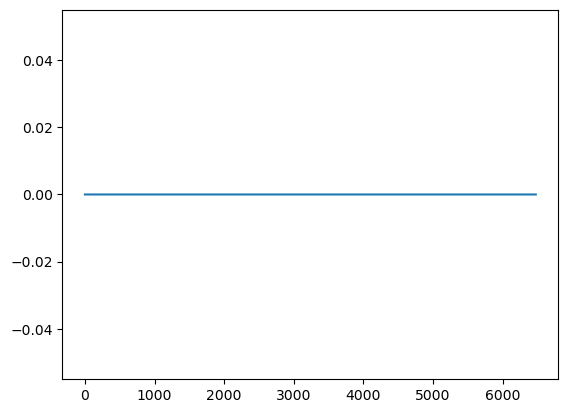

In [47]:
plt.plot(data['ALL'])

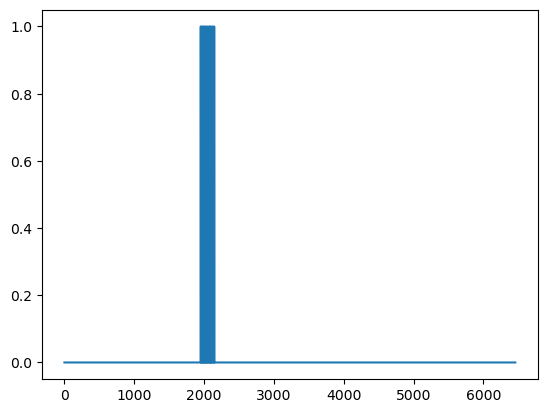

In [15]:
plt.plot(data.AA2)

In [34]:
readcdi(mddir+'gccmd_long3.cdi',data)

FileNotFoundError: [Errno 2] No such file or directory: '/media/pangpang/data_ex1/10AT_5GCend/hpc/cmd_from_ligamd/7/downloadgccmd_long3.cdi'

In [33]:
readcdi(mddir+'/gccmd_long3.cdi',data).to_csv()

10000


,ALL391ALLpos,ALL391ALLrad,ALL391ALLang,AA1392AA1pos,AA1392AA1rad,AA1392AA1ang,BA1393BA1pos,BA1393BA1rad,BA1393BA1ang,CA1394CA1pos,...,AA3408AA3ang,BA3409BA3pos,BA3409BA3rad,BA3409BA3ang,CA3410CA3pos,CA3410CA3rad,CA3410CA3ang,DA3411DA3pos,DA3411DA3rad,DA3411DA3ang
0,6.850,2.192,65.464968,7.355,19.587,-140.675160,9.300,17.914,119.808918,5.275,...,-26.656051,3.930,21.647,66.038217,7.080,25.401,-61.566879,5.570,25.570,-179.770701
1,6.785,2.027,48.611465,6.560,19.713,-118.031848,8.680,18.314,146.464969,5.870,...,-18.745223,2.940,22.187,94.700637,6.595,24.363,-46.261147,6.670,24.737,135.687899
2,6.900,1.764,67.585988,6.410,19.989,-112.356688,8.685,19.327,147.898090,6.135,...,-45.859873,3.395,22.024,87.019109,6.495,24.188,-41.617835,7.140,25.187,120.554141
3,6.835,1.607,90.171975,6.780,19.624,-121.242039,9.050,19.156,130.299364,5.615,...,-40.012739,4.060,21.081,63.745223,7.020,24.295,-57.726115,6.095,26.580,167.617835
4,6.800,1.477,59.675159,6.425,19.277,-102.038217,8.555,18.264,149.445860,6.005,...,-20.121019,2.990,22.658,101.006370,6.975,25.424,-51.936306,6.195,25.964,162.401275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,...,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000
9996,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,...,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000
9997,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,...,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000
9998,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,...,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000


In [13]:
data.trajx3000

0       66.687500
1       67.375000
2       67.625000
3       67.312500
4       68.687500
          ...    
6474    60.250000
6475    69.551471
6476    54.851103
6477    67.663603
6478    66.990809
Name: trajx3000, Length: 6479, dtype: float64

In [22]:
select(data,sel={'index':[],'series':[],'name':['P'],'resname':[],'resid':[],'chain':[],'element':[]},selname='ATP')
curvedata=curves(data,'ATP',deffnm='ATPatligamd_rep3',outdir='/media/pangpang/data_ex1/curve/ligamd',snap=(0,3300,1))

<ipython-input-3-1c3c7b5f6973>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[selname][i]=1-mode


sh command: cp /home/pangpang/curve+/standard_b.lib ATPatligamd_rep3_b.lib
sh command: cp /home/pangpang/curve+/standard_s.lib ATPatligamd_rep3_s.lib
6600
 DA29P  encircle -1 at frame  1
 DA30P  encircle -1 at frame  1
 DA29P  encircle -1 at frame  2
 DA30P  encircle -1 at frame  2
 DA35P  encircle -1 at frame  2
 DA30P  encircle -1 at frame  3
 DA35P  encircle -1 at frame  3
 DA30P  encircle -1 at frame  4
 DA34P  encircle -1 at frame  7
 DC22P  encircle -1 at frame  8
 DA30P  encircle -1 at frame  8
 DA34P  encircle -1 at frame  8
 DC22P  encircle -1 at frame  9
 DA30P  encircle -1 at frame  9
 DA35P  encircle -1 at frame  9
 DA35P  encircle -1 at frame  10
 DG24P  encircle -1 at frame  12
 DG24P  encircle -1 at frame  13
 DC22P  encircle -1 at frame  16
 DC22P  encircle -1 at frame  17
 DC22P  encircle -1 at frame  20
 DG39P  encircle -1 at frame  20
 DC36P  encircle -1 at frame  21
 DC37P  encircle -1 at frame  21
 DG39P  encircle -1 at frame  21
 DC37P  encircle -1 at frame  22
 D

In [153]:
ft=open('test.bin','wb')
title='Amber trjectory file write by quzhi'
ft.write(("{0:<80}".format(title)).encode())
ft.write(b"\x0A")
ft.close()

In [13]:
data

,series,name,resname,resid,x,y,z,mass,element,trajx0,...,trajz9996,trajx9997,trajy9997,trajz9997,trajx9998,trajy9998,trajz9998,trajx9999,trajy9999,trajz9999
0,1,HO5',DC5,1,14.686,57.563,56.227,1.00794,H,11.117,...,75.482,37.245,50.822,75.012,36.237,50.122,74.445,37.089,49.766,75.050
1,2,O5',DC5,1,15.476,57.392,56.746,15.99940,O,11.607,...,75.460,37.938,51.403,74.691,36.769,50.877,74.182,37.681,50.517,75.136
2,3,C5',DC5,1,15.567,57.941,58.047,12.01070,C,11.431,...,75.802,39.206,50.732,74.890,38.004,50.582,74.793,39.017,50.157,75.591
3,4,H5',DC5,1,14.544,57.933,58.423,1.00794,H,10.458,...,76.843,39.278,50.653,75.975,37.873,50.596,75.875,38.983,49.882,76.645
4,5,H5'',DC5,1,15.765,59.010,57.964,1.00794,H,11.395,...,75.677,40.029,51.352,74.534,38.788,51.315,74.601,39.611,51.069,75.543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6453,6454,NA,NA,386,55.978,47.929,64.898,22.98977,NA,53.074,...,23.026,40.886,62.669,25.473,39.159,60.637,27.257,39.300,62.913,28.165
6454,6455,NA,NA,387,26.562,39.686,23.159,22.98977,NA,67.201,...,42.319,13.161,38.280,41.776,13.956,37.835,43.916,13.374,37.166,45.672
6455,6456,NA,NA,388,18.893,37.734,60.195,22.98977,NA,21.854,...,52.302,30.911,60.152,51.743,31.272,58.561,53.036,32.468,57.910,53.481
6456,6457,NA,NA,389,13.187,84.450,37.825,22.98977,NA,2.383,...,21.177,39.043,41.545,20.088,39.688,39.650,20.834,39.545,39.693,21.863


In [24]:
readcdi('../curve/10AT_5GC_LIGAMD0.1/CAcom.cdi',fo='../curve/10AT_5GC_LIGAMD0.1/com.csv')

ValueError: invalid literal for int() with base 10: '   5040  24618  -1434  39105\n'

In [40]:
lib=pd.read_csv('mol.csv')
lib.element=lib.element.fillna('NA')

In [29]:
data[data['ALL']==1]['name']='NZ'

<ipython-input-29-6b4ece63f271>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[data['ALL']==1]['name']='NZ'


In [44]:
data.loc[data['ALL']==1].loc['name']='test'

/home/pangpang/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [46]:
data.loc[data['ALL']==1,'name']='CA1'

In [96]:
data['name'][1412]

'X1'

In [116]:
curvedata.to_csv('curve.csv')

In [54]:
def writetrj(data,outfile='out.trj',trajname='traj',snap=(0,2500,1),title='Amber trjectory file write by quzhi'):
    fo=open(outfile,'wb')
    fo.write(("{0:<80}".format(title)).encode())
    fo.write(b'\x0A')
    for s in range(snap[0],snap[1],snap[2]):
        x=trajname+'x'+str(s)
        y=trajname+'y'+str(s)
        z=trajname+'z'+str(s)
        count=0
        for i in data.index:
            fo.write("{0:>8.3f}".format(data[x][i]).encode())
            count+=1
            if count>=10:
                count=0
                fo.write(b'\x0A')
            fo.write("{0:>8.3f}".format(data[y][i]).encode())
            count+=1
            if count>=10:
                count=0
                fo.write(b'\x0A')
            fo.write("{0:>8.3f}".format(data[z][i]).encode())
            count+=1
            if count>=10:
                count=0
                fo.write(b'\x0A')
        fo.write(b'\x0A')
        fo.write("{0:>8.3f}".format(9999).encode())
        fo.write("{0:>8.3f}".format(9999).encode())
        fo.write("{0:>8.3f}".format(9999).encode())
        fo.write(b'\x0A')
    fo.close()
    return

In [5]:
def gapr(data):
    select(data,sel={'index':[],'series':[],'name':['CA'],'resname':[],'resid':[],'chain':[],'element':[]},selname='ALL')
#    select(data,sel={'index':[],'series':[],'name':['CA'],'resname':[],'resid':[*range(43,80)],'chain':[],'element':[]},selname='AA1')
    select(data,sel={'index':[],'series':[],'name':['CA'],'resname':[],'resid':[*range(43,62)],'chain':[],'element':[]},selname='AN1')
    select(data,sel={'index':[],'series':[],'name':['CA'],'resname':[],'resid':[*range(63,80)],'chain':[],'element':[]},selname='AC1')
#    select(data,sel={'index':[],'series':[],'name':['CA'],'resname':[],'resid':[*range(121,158)],'chain':[],'element':[]},selname='BA1')
    select(data,sel={'index':[],'series':[],'name':['CA'],'resname':[],'resid':[*range(121,140)],'chain':[],'element':[]},selname='BN1')
    select(data,sel={'index':[],'series':[],'name':['CA'],'resname':[],'resid':[*range(141,158)],'chain':[],'element':[]},selname='BC1')
#    select(data,sel={'index':[],'series':[],'name':['CA'],'resname':[],'resid':[*range(199,236)],'chain':[],'element':[]},selname='CA1')
    select(data,sel={'index':[],'series':[],'name':['CA'],'resname':[],'resid':[*range(199,218)],'chain':[],'element':[]},selname='CN1')
    select(data,sel={'index':[],'series':[],'name':['CA'],'resname':[],'resid':[*range(219,236)],'chain':[],'element':[]},selname='CC1')
#    select(data,sel={'index':[],'series':[],'name':['CA'],'resname':[],'resid':[*range(277,314)],'chain':[],'element':[]},selname='DA1')
    select(data,sel={'index':[],'series':[],'name':['CA'],'resname':[],'resid':[*range(277,296)],'chain':[],'element':[]},selname='DN1')
    select(data,sel={'index':[],'series':[],'name':['CA'],'resname':[],'resid':[*range(297,314)],'chain':[],'element':[]},selname='DC1')
    select(data,sel={'index':[],'series':[],'name':['CA'],'resname':[],'resid':[*range(84,95)],'chain':[],'element':[]},selname='AA2')
    select(data,sel={'index':[],'series':[],'name':['CA'],'resname':[],'resid':[*range(162,173)],'chain':[],'element':[]},selname='BA2')
    select(data,sel={'index':[],'series':[],'name':['CA'],'resname':[],'resid':[*range(240,251)],'chain':[],'element':[]},selname='CA2')
    select(data,sel={'index':[],'series':[],'name':['CA'],'resname':[],'resid':[*range(318,329)],'chain':[],'element':[]},selname='DA2')
    select(data,sel={'index':[],'series':[],'name':['CA'],'resname':[],'resid':[*range(98,115)],'chain':[],'element':[]},selname='AA3')
    select(data,sel={'index':[],'series':[],'name':['CA'],'resname':[],'resid':[*range(176,193)],'chain':[],'element':[]},selname='BA3')
    select(data,sel={'index':[],'series':[],'name':['CA'],'resname':[],'resid':[*range(254,271)],'chain':[],'element':[]},selname='CA3')
    select(data,sel={'index':[],'series':[],'name':['CA'],'resname':[],'resid':[*range(332,349)],'chain':[],'element':[]},selname='DA3')
    data=addcom(data,selname='ALL')
#    data=addcom(data,selname='AA1')
#    data=addcom(data,selname='BA1')
#    data=addcom(data,selname='CA1')
#    data=addcom(data,selname='DA1')
    data=addcom(data,selname='AN1')
    data=addcom(data,selname='BN1')
    data=addcom(data,selname='CN1')
    data=addcom(data,selname='DN1')
    data=addcom(data,selname='AC1')
    data=addcom(data,selname='BC1')
    data=addcom(data,selname='CC1')
    data=addcom(data,selname='DC1')
    data=addcom(data,selname='AA2')
    data=addcom(data,selname='BA2')
    data=addcom(data,selname='CA2')
    data=addcom(data,selname='DA2')
    data=addcom(data,selname='AA3')
    data=addcom(data,selname='BA3')
    data=addcom(data,selname='CA3')
    data=addcom(data,selname='DA3')
    return data
def PCNA(data):
    select(data,sel={'index':[],'series':[],'name':['CA'],'resname':[],'resid':[],'chain':[],'element':[]},selname='ALL')
    data=addcom(data,selname='ALL')
    return data
def writeparm(data,parmfile='out.parm'):
#this parm file do not contain parameters!!!!!
#only use for curve analysis
    fp=open(parmfile,'w')
    fp.writelines('''%VERSION  VERSION_STAMP = V0001.000  DATE = 10/09/21 20:21:36                  
%FLAG TITLE                                                                     
%FORMAT(20a4)                                                                   
default_name                                                                    
%FLAG POINTERS                                                                  
%FORMAT(10I8)
''')
    fp.writelines("{0:>8d}{1:>8d}{2:>8d}{3:>8d}{4:>8d}{5:>8d}{6:>8d}{7:>8d}{8:>8d}{9:>8d}\n".\
    format(len(data.index),len(data.name.value_counts()),0,0,0,0,0,0,0,0))
#  NATOM    : total number of atoms 
#  NTYPES   : total number of distinct atom types
    fp.writelines("{0:>8d}{1:>8d}{2:>8d}{3:>8d}{4:>8d}{5:>8d}{6:>8d}{7:>8d}{8:>8d}{9:>8d}\n".\
    format(0,len(data.resid.value_counts()),0,0,0,0,0,0,0,0))
#resid now only support amber format pdb
#
    fp.writelines('''%FLAG ATOM_NAME                                                                 
%FORMAT(20a4)                                                                                                                               
''')
    line=''
    count=0
    for i in data.index:
        line=line+"{0:<4}".format(data.name[i])
        count+=1
        if count>=20:
            count=0
            fp.writelines(line+'\n')
            line=''
    fp.writelines(line+'\n')
    fp.writelines('''%FLAG RESIDUE_LABEL                                                             
%FORMAT(20a4)                                                                   
''')
    line=''
    count=0
    temp=''
    respointer=[]
    for i in data.index:
        if data.resid[i]!=temp:
            respointer.append(i+1)
            temp=data.resid[i]            
            line=line+"{0:<4}".format(data.resname[i])
            count+=1
            if count>=20:
                count=0
                fp.writelines(line+'\n')
                line=''
    fp.writelines(line+'\n')
    fp.writelines('''%FLAG RESIDUE_POINTER                                                           
%FORMAT(10I8)                                                                   
''') 
    line=''
    count=0
    for i in respointer:
        line=line+"{0:>8d}".format(i)
        count+=1
        if count>=10:
            count=0
            fp.writelines(line+'\n')
            line=''
    fp.writelines(line+'\n')
    fp.close()
    return